In [3]:
from matplotlib.pyplot import get
import numpy as np
import pandas as pd
import sys
import os
import pickle
import csv
import ipdb
from tqdm import tqdm
from collections import OrderedDict, defaultdict
# import random

from training.utils import load_obj, save_obj
from training.data import load_data
from training.dataset import _preprocess_call_data, preprocess_and_make_dataset

from training.modelling.metrics import F1, Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

np.random.seed(1)

CONFIG = {
    'pilot_data': 'feb16-mar15_data',
    'current_week': 11,
    'week': 'week11'
}
T = 12

calling_files = ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621']


In [4]:
pilot_beneficiary_data, pilot_call_data = load_data(CONFIG['pilot_data'])
pilot_call_data = _preprocess_call_data(pilot_call_data)

complete_group = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')
all_user_ids = complete_group['user_id'].to_list()
rmab_group = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')
round_robin_group = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

arm_dict = {}
for user_id in rmab_user_ids:
    arm_dict[user_id] = 'rmab'
for user_id in round_robin_user_ids:
    arm_dict[user_id] = 'round_robin'

with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

intervention_dict = {}
group_cluster_size = defaultdict(lambda: defaultdict(lambda: 0))
for file in calling_files:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            curr_cluster = complete_group[complete_group['user_id'] == user_id]['cluster'].item()
            if user_id not in intervention_dict:
                intervention_dict[user_id] = [int(file.split('_')[1][4:])]
            else:
                intervention_dict[user_id].append(int(file.split('_')[1][4:]))
            if user_id in rmab_user_ids:
                group_cluster_size['rmab'][curr_cluster] += 1
            elif user_id in round_robin_user_ids:
                group_cluster_size['round_robin'][curr_cluster] += 1

rmab_cluster_list = [(group_cluster_size['rmab'][cluster], cluster) for cluster in range(40)]
round_robin_cluster_list = [(group_cluster_size['round_robin'][cluster], cluster) for cluster in range(40)]

rmab_cluster_list = sorted(rmab_cluster_list, reverse=True)[:5]
round_robin_cluster_list = sorted(round_robin_cluster_list, reverse=True)[:5]

top_cluster_list = {'rmab': rmab_cluster_list, 'round_robin': round_robin_cluster_list}



2021-08-30 11:25:07,162 - INFO - load_data - Loading data from folder 'feb16-mar15_data'
2021-08-30 11:25:07,175 - INFO - load_call_data - Found 1 files in 'feb16-mar15_data/call'.
2021-08-30 11:25:07,175 - INFO - load_call_data - Loading and cleaning call data.
100%|██████████| 1/1 [00:12<00:00, 12.54s/it]
2021-08-30 11:25:24,201 - WARNING - gest_age_to_list - introivr is not a valid gestation age.
2021-08-30 11:25:24,223 - WARNING - gest_age_to_list - introivr is not a valid gestation age.
2021-08-30 11:25:24,228 - WARNING - gest_age_to_list - introivr is not a valid gestation age.
2021-08-30 11:25:24,233 - WARNING - gest_age_to_list - introivr is not a valid gestation age.


2021-08-30 11:25:24,269 - WARNING - gest_age_to_list - introivr is not a valid gestation age.


2021-08-30 11:25:24,613 - INFO - load_call_data - Call data contains 842588 relevant call records for 23516 beneficiaries.
2021-08-30 11:25:24,628 - INFO - load_data - Successfully loaded and cleaned beneficiary and call data.
2021-08-30 11:25:24,629 - INFO - load_data - Beneficiary data contains data for 23516 beneficiaries
2021-08-30 11:25:24,637 - INFO - load_data - Call data contains 842588 call records for 23516 beneficiaries
/Users/vermashresth/Documents/armman-pipeline-latest/training/dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["duration"] = data["duration"].astype('uint8')
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifi

In [5]:
df = pd.read_csv('/Users/vermashresth/Documents/armman-pipeline-latest/outputs/analysis_lists/all_analysis_week_12.csv')

out_dict = {'user_id': [], 'pre-action state': [], 'action': [], 'post-action state': []}

for user_id in tqdm(all_user_ids):
    curr_row = df[df['user_id'] == user_id]

    engagements = []
    for i in range(T):
        counte = int(curr_row['week{}_E/C'.format(i)].item().split('/')[0])
        engagements.append(counte)

    if user_id in intervention_dict:
        user_intervention_list = intervention_dict[user_id]
    else:
        user_intervention_list = []

    assert len(engagements) == T
    for i in range(T-1):
        start_state = 'L' if engagements[i] > 0 else 'H'
        next_state = 'L' if engagements[i + 1] > 0 else 'H'
        action = 'Intervention' if i in user_intervention_list else 'No Intervention'
        out_dict['user_id'].append(user_id)
        out_dict['pre-action state'].append(start_state)
        out_dict['action'].append(action)
        out_dict['post-action state'].append(next_state)

transitions_df = pd.DataFrame(out_dict)


100%|██████████| 23003/23003 [00:27<00:00, 830.02it/s]


In [58]:
transitions_df.to_csv('outputs/pilot_transitions.csv')

In [8]:
with open('gt_beneficiary_probs.pkl', 'rb') as fr:
    gt = pickle.load(fr)
fr.close()
valid = (~pd.Series(gt[:, 0]).isna() & ~pd.Series(gt[:, 1]).isna()).values
len(set(list(zip(gt[:, 0][valid], gt[:, 1][valid])))), valid.sum()


(704, 3469)

In [12]:
print(pd.Series(gt[:, 0]).isna().sum(), pd.Series(gt[:, 0]).shape)
print(pd.Series(gt[:, 1]).isna().sum(), pd.Series(gt[:, 1]).shape)


737 (4238,)
32 (4238,)


In [13]:
gt_beneficiries_transition_prob_file = 'outputs/cluster_outputs/gt_beneficiary_probs.pkl'

with open(gt_beneficiries_transition_prob_file, 'rb') as fr:
    gt = pickle.load(fr)
fr.close()
valid = (~pd.Series(gt[:, 0]).isna() & ~pd.Series(gt[:, 1]).isna()).values
len(set(list(zip(gt[:, 0][valid], gt[:, 1][valid])))), valid.sum()


(170, 6225)

In [15]:
print(pd.Series(gt[:, 0]).isna().sum(), pd.Series(gt[:, 0]).shape)
print(pd.Series(gt[:, 1]).isna().sum(), pd.Series(gt[:, 1]).shape)

9752 (23003,)
7026 (23003,)


In [ ]:
clustered_transition_prob_df_csvs  = ["outputs/cluster_outputs/weekly_kmeans_transition_probabilities_500.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_10.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_100.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_75.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_20.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_50.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_40.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_30.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_200.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_300.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_400.csv"]

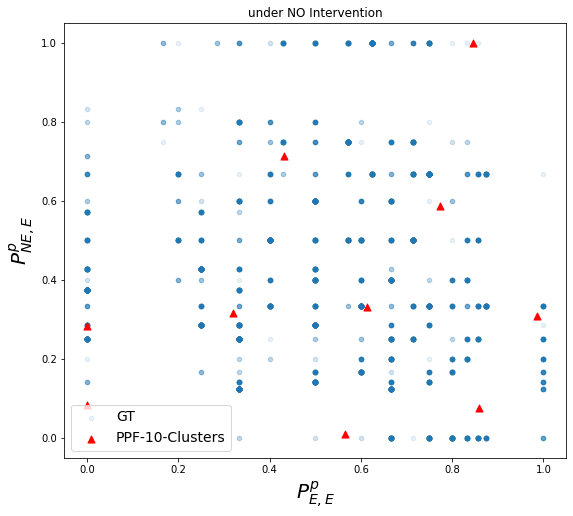

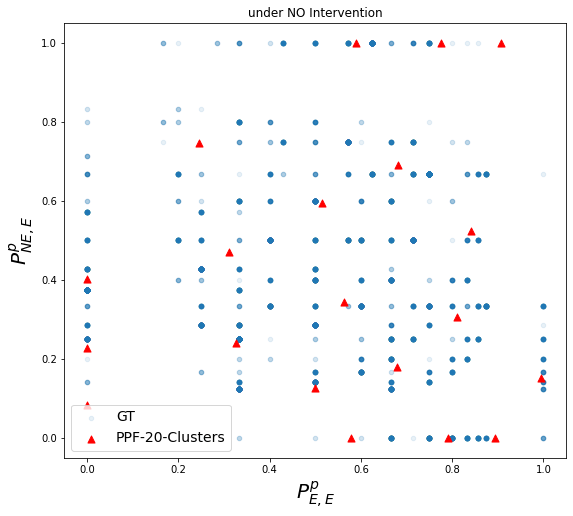

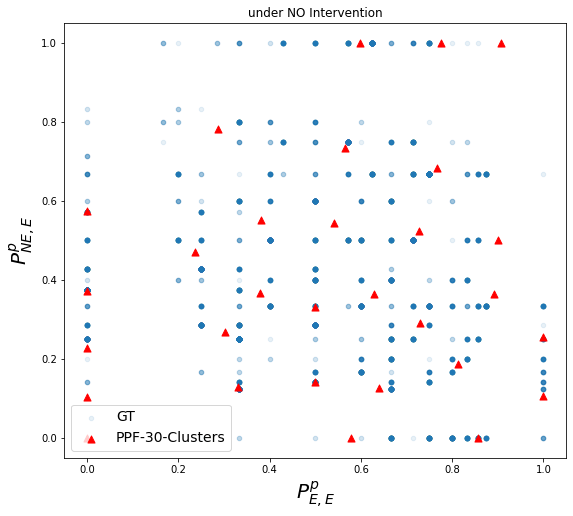

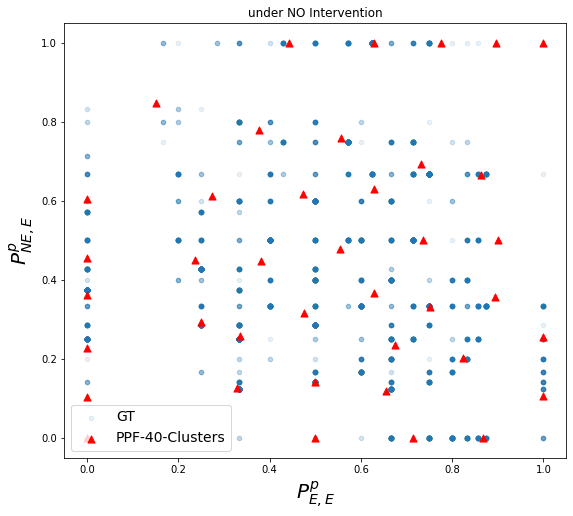

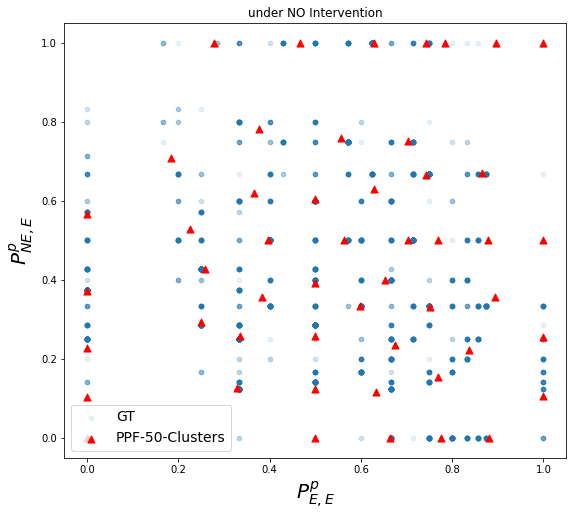

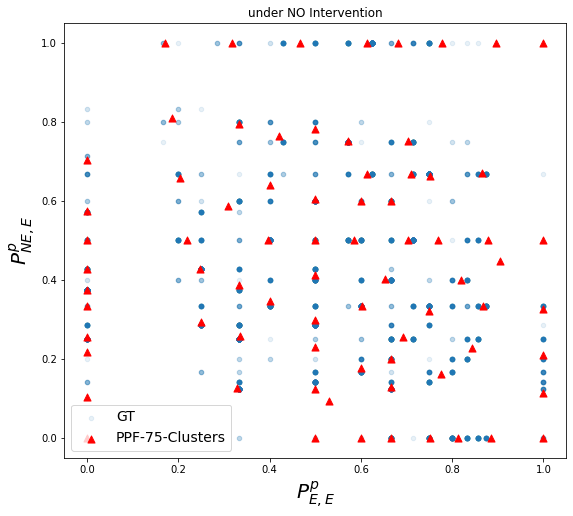

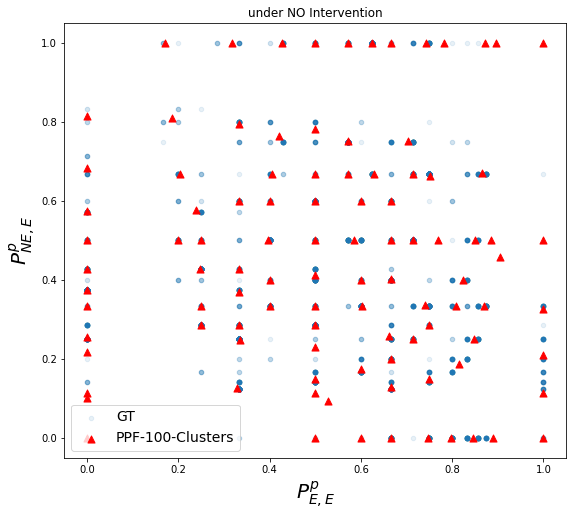

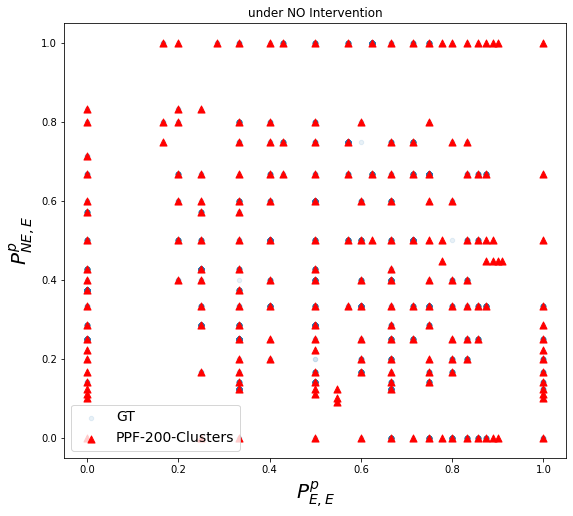

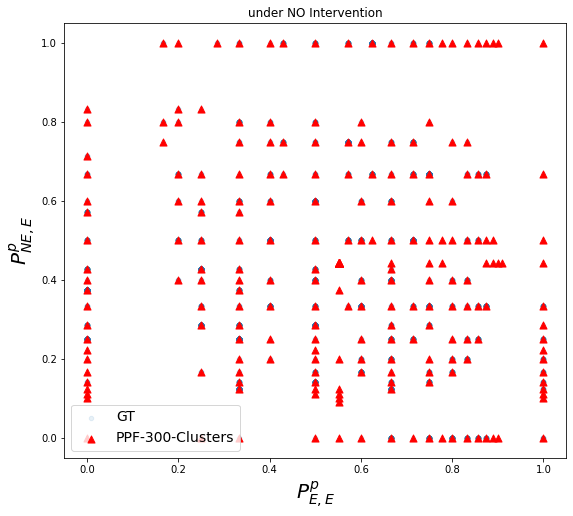

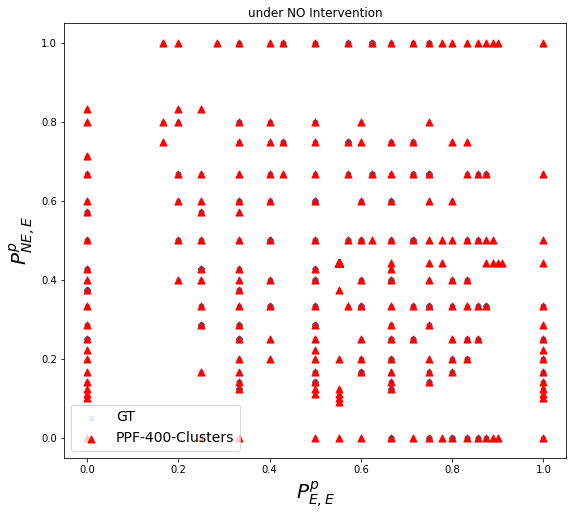

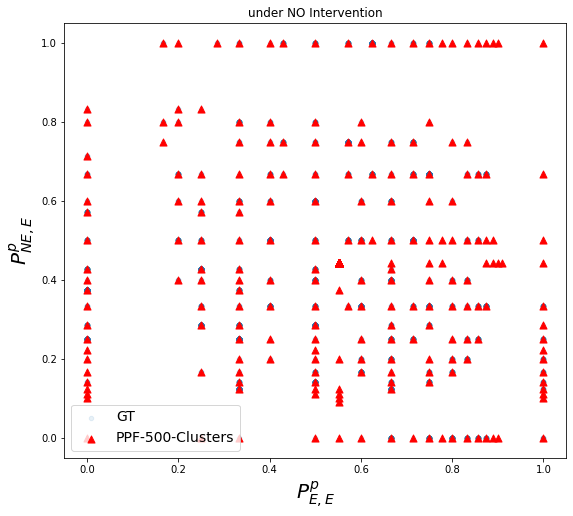

In [232]:
import numpy as np
from numpy.core.fromnumeric import size
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import ipdb


# Enter pickle file containing ground truth transition probablity array
# TODO: Ground Truth currently must be containing only passive action probs. 
# We would need active actions ones as well
gt_beneficiries_transition_prob_file = 'outputs/cluster_outputs/gt_beneficiary_probs.pkl'

# Enter paths to csv files containing clustered transition probablities, 
# Will generate two plots corresponding to every file - (intervention probs, non-intervention probs)
clustered_transition_prob_df_csvs  = [
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_10.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_20.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_30.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_40.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_50.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_75.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_100.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_200.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_300.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_400.csv",
"outputs/cluster_outputs/weekly_kmeans_transition_probabilities_500.csv"]

# Enter label to show for every output csv file. This will show up in plots
exp_labels = ['PPF-10-Clusters',
              'PPF-20-Clusters',
             'PPF-30-Clusters',
             'PPF-40-Clusters',
             'PPF-50-Clusters',
             'PPF-75-Clusters',
             'PPF-100-Clusters',
             'PPF-200-Clusters',
             'PPF-300-Clusters',
             'PPF-400-Clusters',
             'PPF-500-Clusters']


n_exps =  len(clustered_transition_prob_df_csvs)

with open(gt_beneficiries_transition_prob_file, 'rb') as fr:
    gt = pickle.load(fr)
fr.close()

for idx, csv_file in enumerate(clustered_transition_prob_df_csvs):
    df20 = pd.read_csv(csv_file)
    plt.figure(figsize=(9,8))

#     plt.subplot(n_exps,2,1+idx*2)

    vals20_x = np.array(df20['P(L, N, L)'].to_list())
    vals20_y = np.array(df20['P(H, N, L)'].to_list())

    plt.scatter(gt[:, 0], gt[:, 1], s=20, label='GT', alpha=0.1)
    plt.scatter(vals20_x, vals20_y, marker='^', s=50, label=exp_labels[idx], c='red')
    plt.xlabel(r'$P_{E, E}^p$',fontsize=20)
    plt.ylabel(r'$P_{NE, E}^p$',fontsize=20)
    plt.legend(fontsize=14)
    plt.title(r'under NO Intervention')
    
#     plt.subplot(n_exps,2,2+idx*2)

#     vals20_x = np.array(df20['P(L, I, L)'].to_list())
#     vals20_y = np.array(df20['P(H, I, L)'].to_list())

#     plt.scatter(all_probs['P(L, I, L)'], all_probs['P(H, I, L)'], s=10, label='GT')
#     plt.scatter(vals20_x, vals20_y, marker='^', s=50, label=exp_labels[idx], c='red')
#     plt.xlabel(r'$P_{E, E}^a$',fontsize=20)
#     plt.ylabel(r'$P_{NE, E}^a$',fontsize=20)
#     plt.legend(fontsize=14)
#     plt.title(r'under Intervention')
    plt.savefig(f'outputs/cluster_outputs/plots/clustered_prob_viz_{exp_labels[idx]}.png', dpi=500, bbox_inches='tight')
    plt.show()
    


In [59]:
us1 = transitions_df[(transitions_df['pre-action state']=='H') &
               (transitions_df['post-action state']=='L') &
               (transitions_df['action']=='No Intervention')]['user_id'].values

us2 = transitions_df[(transitions_df['pre-action state']=='L') &
               (transitions_df['post-action state']=='L') &
               (transitions_df['action']=='No Intervention')]['user_id'].values

transitions_df[(transitions_df['user_id'].isin(us1)) &
              (transitions_df['user_id'].isin(us2))]['user_id'].nunique()

8722

In [66]:
transitions_df['magic'] = transitions_df.apply(lambda x: x['pre-action state']+'-'+x['action']+'-'+x['post-action state'], axis=1)

In [73]:
count1 = transitions_df[transitions_df['magic']=='H-No Intervention-L'].groupby('user_id')['user_id'].count()
count2 = transitions_df[transitions_df['magic']=='L-No Intervention-L'].groupby('user_id')['user_id'].count()

transitions_df[(transitions_df['user_id'].isin(count1[count1>=3].index)) &
              (transitions_df['user_id'].isin(count2[count2>=3].index))]['user_id'].nunique()

922

In [80]:
len(set(count1[count1>=3].index).intersection(set(count2[count2>=3].index)))

922

In [17]:
def get_transition_probabilities(beneficiaries, transitions, min_support=1):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}


In [18]:
user_probs, sup = get_transition_probabilities([all_user_ids[0]], transitions_df)


In [19]:
all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm(all_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], transitions_df)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23003/23003 [04:10<00:00, 91.96it/s]


In [21]:
all_probs

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)"
0,2394384.0,1.0,0.0,NaN,NaN,1.0,0.0,1.000000,0.000000
1,2388891.0,NaN,NaN,NaN,NaN,0.0,1.0,0.100000,0.900000
2,2404208.0,NaN,NaN,NaN,NaN,0.5,0.5,0.600000,0.400000
3,2388931.0,NaN,NaN,0.0,1.0,1.0,0.0,0.500000,0.500000
4,2392202.0,NaN,NaN,0.0,1.0,NaN,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
22998,2400463.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
22999,2398012.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
23000,2397484.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
23001,2397539.0,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,0.909091


In [28]:
all_probs['P(H, N, L)'].isna().sum(), all_probs['P(L, N, L)'].isna().sum(), all_probs[~all_probs['P(H, N, L)'].isna() & ~all_probs['P(L, N, L)'].isna()].shape

(3869, 6044, (13090, 9))

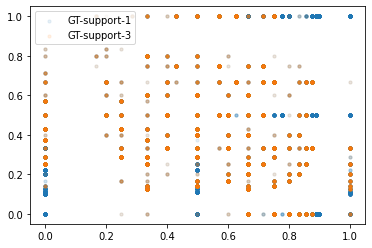

In [35]:
import matplotlib.pyplot as plt
plt.scatter(all_probs['P(L, N, L)'], all_probs['P(H, N, L)'], s=10, label='GT-support-1', alpha=0.1)
plt.scatter(gt[:, 0], gt[:, 1], s=10, label='GT-support-3', alpha=0.1)
plt.legend()

In [37]:
old_trans_df = pd.read_csv('/Users/vermashresth/Documents/armman-pipeline-latest/may_data/RMAB_one_month/weekly_transitions_SI_single_group.csv')


In [45]:
transitions_df.groupby('user_id')['user_id'].count()

user_id
2385611    11
2385612    11
2385613    11
2385614    11
2385615    11
           ..
2409132    11
2409133    11
2409134    11
2409135    11
2409136    11
Name: user_id, Length: 23003, dtype: int64

In [44]:
old_trans_df.groupby('user_id')['user_id'].count()

user_id
2276450    29
2276467    29
2276476    29
2276487    29
2276490    29
           ..
2302701    29
2302848    28
2302916    29
2302927    29
2302937    29
Name: user_id, Length: 4238, dtype: int64

In [58]:
arr = np.arange(10, dtype=np.float)
arr[0] = np.nan
arr[4] = np.nan
arr

array([nan,  1.,  2.,  3., nan,  5.,  6.,  7.,  8.,  9.])

In [59]:
np.nanmean(arr)

5.125

In [51]:
old_trans_df[old_trans_df['user_id']==2302927]

,Unnamed: 0,user_id,pre-action state,action,post-action state
121880,121880,2302927,L,No Intervention,H
121881,121881,2302927,H,No Intervention,L
121882,121882,2302927,L,No Intervention,H
121883,121883,2302927,H,No Intervention,L
121884,121884,2302927,L,No Intervention,H
121885,121885,2302927,H,No Intervention,L
121886,121886,2302927,L,No Intervention,L
121887,121887,2302927,L,No Intervention,L
121888,121888,2302927,L,No Intervention,L
121889,121889,2302927,L,No Intervention,L


In [46]:
call_1 = pd.read_csv('/Users/vermashresth/Documents/armman-pipeline-latest/may_data/call/1.csv')

In [53]:
call_1[call_1['user_id']==2302927]['startdatetime'].min()

'2020-08-01 10:40:11'

In [54]:
call_1[call_1['user_id']==2302927]['startdatetime'].max()

'2021-02-08 11:43:14'

In [98]:
all_probs[~all_probs['P(H, N, L)'].isna()]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",user_id
1,2388891.0,NaN,NaN,NaN,NaN,NaN,NaN,0.100000,0.900000,2388891.0
2,2404208.0,NaN,NaN,NaN,NaN,0.50,0.50,0.600000,0.400000,2404208.0
4,2392202.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,2392202.0
5,2388963.0,NaN,NaN,NaN,NaN,0.25,0.75,0.500000,0.500000,2388963.0
6,2394698.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,2394698.0
...,...,...,...,...,...,...,...,...,...,...
22998,2400463.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,2400463.0
22999,2398012.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,2398012.0
23000,2397484.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,2397484.0
23001,2397539.0,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,0.909091,2397539.0


In [99]:
all_probs[~all_probs['P(L, N, L)'].isna()]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",user_id
0,2394384.0,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,2394384.0
2,2404208.0,NaN,NaN,NaN,NaN,0.500000,0.500000,0.600000,0.400000,2404208.0
3,2388931.0,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,2388931.0
5,2388963.0,NaN,NaN,NaN,NaN,0.250000,0.750000,0.500000,0.500000,2388963.0
9,2405518.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.375000,0.625000,2405518.0
...,...,...,...,...,...,...,...,...,...,...
22987,2393161.0,NaN,NaN,NaN,NaN,0.400000,0.600000,0.400000,0.600000,2393161.0
22990,2399795.0,NaN,NaN,NaN,NaN,1.000000,0.000000,0.142857,0.857143,2399795.0
22992,2392263.0,NaN,NaN,NaN,NaN,0.333333,0.666667,0.428571,0.571429,2392263.0
22994,2406507.0,NaN,NaN,NaN,NaN,0.714286,0.285714,0.750000,0.250000,2406507.0


In [100]:
all_probs[~(all_probs['P(H, N, L)'].isna()) & ~(all_probs['P(L, N, L)'].isna())]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",user_id
2,2404208.0,NaN,NaN,NaN,NaN,0.500000,0.500000,0.600000,0.400000,2404208.0
5,2388963.0,NaN,NaN,NaN,NaN,0.250000,0.750000,0.500000,0.500000,2388963.0
9,2405518.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.375000,0.625000,2405518.0
14,2389056.0,NaN,NaN,NaN,NaN,0.571429,0.428571,1.000000,0.000000,2389056.0
24,2398365.0,NaN,NaN,NaN,NaN,0.333333,0.666667,0.800000,0.200000,2398365.0
...,...,...,...,...,...,...,...,...,...,...
22987,2393161.0,NaN,NaN,NaN,NaN,0.400000,0.600000,0.400000,0.600000,2393161.0
22990,2399795.0,NaN,NaN,NaN,NaN,1.000000,0.000000,0.142857,0.857143,2399795.0
22992,2392263.0,NaN,NaN,NaN,NaN,0.333333,0.666667,0.428571,0.571429,2392263.0
22994,2406507.0,NaN,NaN,NaN,NaN,0.714286,0.285714,0.750000,0.250000,2406507.0


In [117]:
sv = np.array(list(set(count1[count1>=3].index).intersection(set(count2[count2>=3].index))))
gg = all_probs[~(all_probs['P(H, N, L)'].isna()) & ~(all_probs['P(L, N, L)'].isna())]['user_id'].iloc[:, 0].values

In [118]:
sv.shape, gg.shape

((922,), (6225,))

In [123]:
diff = set(gg).difference(set(sv))

In [124]:
diff

{2392076.0,
 2408460.0,
 2408462.0,
 2408470.0,
 2408471.0,
 2392090.0,
 2408475.0,
 2392092.0,
 2392093.0,
 2408476.0,
 2408477.0,
 2408480.0,
 2392097.0,
 2392098.0,
 2408482.0,
 2408483.0,
 2392103.0,
 2392108.0,
 2408494.0,
 2408497.0,
 2392114.0,
 2392115.0,
 2392117.0,
 2392118.0,
 2408501.0,
 2408504.0,
 2408506.0,
 2408513.0,
 2408515.0,
 2392132.0,
 2408516.0,
 2392134.0,
 2392135.0,
 2408517.0,
 2408518.0,
 2408520.0,
 2408526.0,
 2392144.0,
 2408529.0,
 2392146.0,
 2408531.0,
 2392148.0,
 2392149.0,
 2408532.0,
 2408539.0,
 2408540.0,
 2392157.0,
 2408543.0,
 2392160.0,
 2408547.0,
 2392164.0,
 2408549.0,
 2408553.0,
 2392173.0,
 2408558.0,
 2392175.0,
 2392177.0,
 2392180.0,
 2408565.0,
 2392182.0,
 2408568.0,
 2392185.0,
 2392186.0,
 2408573.0,
 2392191.0,
 2392192.0,
 2408575.0,
 2392194.0,
 2392195.0,
 2392196.0,
 2392198.0,
 2392199.0,
 2392200.0,
 2392204.0,
 2392207.0,
 2392210.0,
 2392211.0,
 2408595.0,
 2392215.0,
 2408599.0,
 2408600.0,
 2408601.0,
 2408602.0,
 240

In [132]:
transitions_df[transitions_df['user_id']==list(diff)[0]]

,user_id,pre-action state,action,post-action state,magic
130438,2392076,L,No Intervention,H,L-No Intervention-H
130439,2392076,H,No Intervention,H,H-No Intervention-H
130440,2392076,H,No Intervention,H,H-No Intervention-H
130441,2392076,H,No Intervention,H,H-No Intervention-H
130442,2392076,H,No Intervention,L,H-No Intervention-L
130443,2392076,L,No Intervention,H,L-No Intervention-H
130444,2392076,H,No Intervention,L,H-No Intervention-L
130445,2392076,L,No Intervention,H,L-No Intervention-H
130446,2392076,H,No Intervention,H,H-No Intervention-H
130447,2392076,H,No Intervention,H,H-No Intervention-H


In [133]:
all_probs[all_probs.iloc[:,0]==list(diff)[0]]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",user_id
11858,2392076.0,NaN,NaN,NaN,NaN,0.0,1.0,0.25,0.75,2392076.0


In [134]:
user_probs, sup = get_transition_probabilities([list(diff)[0]], transitions_df)


In [135]:
user_probs, sup

({'P(L, I, L)': nan,
  'P(L, I, H)': nan,
  'P(H, I, L)': nan,
  'P(H, I, H)': nan,
  'P(L, N, L)': 0.0,
  'P(L, N, H)': 1.0,
  'P(H, N, L)': 0.25,
  'P(H, N, H)': 0.75},
 {'P(L, I, L)': 0,
  'P(L, I, H)': 0,
  'P(H, I, L)': 0,
  'P(H, I, H)': 0,
  'P(L, N, L)': 0,
  'P(L, N, H)': 3,
  'P(H, N, L)': 2,
  'P(H, N, H)': 6})

In [241]:
all_probs['exp_group'] = 'control'
all_probs.loc[all_probs['user_id'].iloc[:,0].isin(round_robin_user_ids), 'exp_group']='round_robin'
all_probs.loc[all_probs['user_id'].iloc[:,0].isin(rmab_user_ids), 'exp_group']='rmab'


In [256]:
old_trans = pd.read_csv('/Users/vermashresth/Documents/armman-pipeline-latest/all_transition_probabilities.csv')
ben_stats = pd.read_csv('may_data/beneficiary_stats_v5.csv')
old_trans['exp_group'] = 'old_control'
old_trans.loc[old_trans['user_id'].isin(ben_stats[ben_stats['Group']=='Google-AI-Calls']['user_id']), 'exp_group'] = 'old_interv'
old_trans

,Unnamed: 0,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",exp_group
0,0,2276450.0,NaN,NaN,NaN,NaN,0.444444,0.555556,0.200000,0.800000,old_interv
1,1,2276467.0,NaN,NaN,NaN,NaN,0.826087,0.173913,0.666667,0.333333,old_control
2,2,2276476.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.037037,0.962963,old_control
3,3,2276487.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.074074,0.925926,old_control
4,4,2276490.0,NaN,NaN,NaN,NaN,0.333333,0.666667,0.038462,0.961538,old_interv
...,...,...,...,...,...,...,...,...,...,...,...
4233,4233,2302701.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.115385,0.884615,old_control
4234,4234,2302848.0,1.0,0.0,NaN,NaN,0.333333,0.666667,0.142857,0.857143,old_interv
4235,4235,2302916.0,NaN,NaN,NaN,NaN,0.687500,0.312500,0.307692,0.692308,old_interv
4236,4236,2302927.0,NaN,NaN,NaN,NaN,0.750000,0.250000,0.444444,0.555556,old_interv


In [261]:
help(sns.kdeplot)

Help on function kdeplot in module seaborn.distributions:

kdeplot(x=None, *, y=None, shade=None, vertical=False, kernel=None, bw=None, gridsize=200, cut=3, clip=None, legend=True, cumulative=False, shade_lowest=None, cbar=False, cbar_ax=None, cbar_kws=None, ax=None, weights=None, hue=None, palette=None, hue_order=None, hue_norm=None, multiple='layer', common_norm=True, common_grid=False, levels=10, thresh=0.05, bw_method='scott', bw_adjust=1, log_scale=None, color=None, fill=None, data=None, data2=None, **kwargs)
    Plot univariate or bivariate distributions using kernel density estimation.
    
    A kernel density estimate (KDE) plot is a method for visualizing the
    distribution of observations in a dataset, analagous to a histogram. KDE
    represents the data using a continuous probability density curve in one or
    more dimensions.
    
    The approach is explained further in the :ref:`user guide <tutorial_kde>`.
    
    Relative to a histogram, KDE can produce a plot that

P(L, I, L)


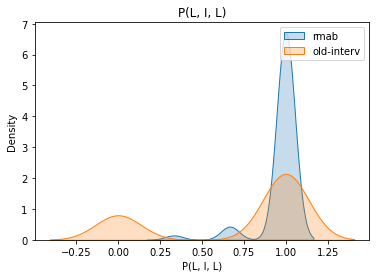




P(L, I, H)


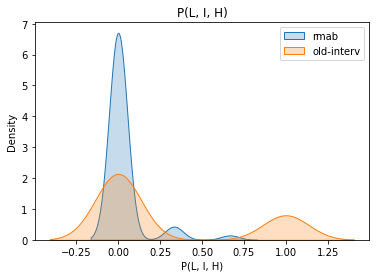




P(H, I, L)


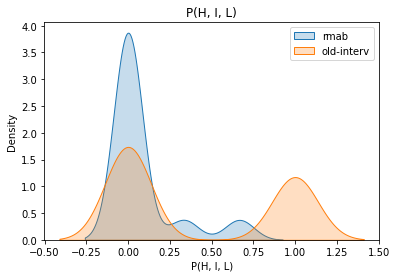




P(H, I, H)


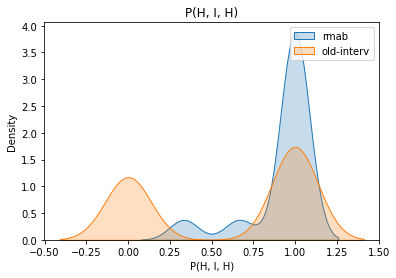




P(L, N, L)


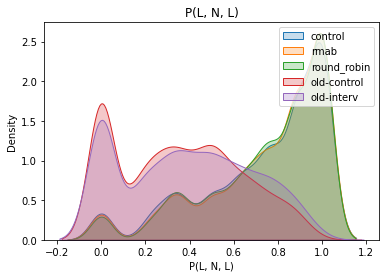




P(L, N, H)


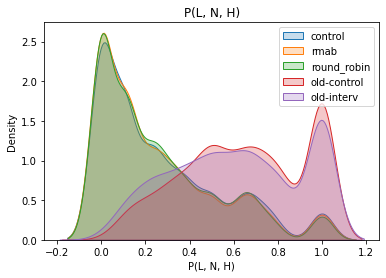




P(H, N, L)


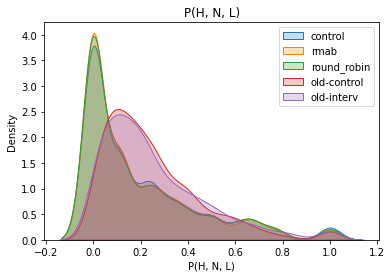




P(H, N, H)


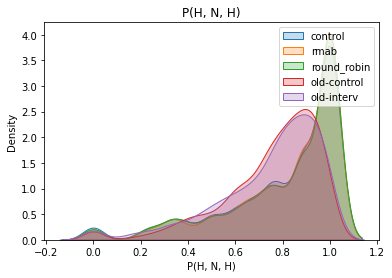

In [263]:
import seaborn as sns
p_cols = [c for c in all_probs.columns if c.startswith('P')]
for col in p_cols:
    print(col)
#     plt.hist(all_probs[col], bins=10)
    sns.kdeplot(all_probs[all_probs['exp_group']=='control'][col], fill=True, label='control', common_norm=True)
    sns.kdeplot(all_probs[all_probs['exp_group']=='rmab'][col], fill=True, label='rmab',common_norm=True )
    sns.kdeplot(all_probs[all_probs['exp_group']=='round_robin'][col], fill=True, label='round_robin', common_norm=True)
    sns.kdeplot(old_trans[old_trans['exp_group']=='old_control'][col], fill=True, label='old-control', common_norm=True)
    sns.kdeplot(old_trans[old_trans['exp_group']=='old_interv'][col], fill=True, label='old-interv',common_norm=True )
    plt.title(col)
    plt.legend()
    
    plt.show()
    print('\n\n')

In [259]:
old_trans[old_trans['exp_group']=='old-control']

,Unnamed: 0,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",exp_group
0,0,2276450.0,NaN,NaN,NaN,NaN,0.444444,0.555556,0.200000,0.800000,old_interv
1,1,2276467.0,NaN,NaN,NaN,NaN,0.826087,0.173913,0.666667,0.333333,old_control
2,2,2276476.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.037037,0.962963,old_control
3,3,2276487.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.074074,0.925926,old_control
4,4,2276490.0,NaN,NaN,NaN,NaN,0.333333,0.666667,0.038462,0.961538,old_interv
...,...,...,...,...,...,...,...,...,...,...,...
4233,4233,2302701.0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.115385,0.884615,old_control
4234,4234,2302848.0,1.0,0.0,NaN,NaN,0.333333,0.666667,0.142857,0.857143,old_interv
4235,4235,2302916.0,NaN,NaN,NaN,NaN,0.687500,0.312500,0.307692,0.692308,old_interv
4236,4236,2302927.0,NaN,NaN,NaN,NaN,0.750000,0.250000,0.444444,0.555556,old_interv
